In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import convolve
from scipy.ndimage import imread
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.io import loadmat
from scipy.ndimage import map_coordinates
from scipy.sparse import csr_matrix
from scipy.sparse import dia_matrix
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import bicg
from scipy.sparse import find
from scipy.misc import imresize
from helpers import *
import cv2

In [2]:
def photo_loss(im1, im2, uv):
    return np.mean(np.sum(np.square(warp(im2, uv) - im1), axis=-1))

def warp(im, uv):
    H, W, C = im.shape
    x, y = np.meshgrid(range(W), range(H))
    x, y = x.astype(np.float32), y.astype(np.float32)
    x2 = x + uv[:,:,0]
    y2 = y + uv[:,:,1]

    return np.dstack([
        map_coordinates(im[:,:,i], [y2.ravel(), x2.ravel()], mode='mirror').reshape((H, W)) for i in range(C)
    ])

In [3]:
def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

print fspecial_gauss(5, 1)

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


In [4]:
# convolution for RGB images
def myconvolve(im, f):
    return np.dstack([
        convolve(im[:,:,i], f) for i in range(3)
    ])

def smooth_loss(u, v, gt):    
    gt_kernels = [[[0,0,0],
               [0,1,-1],
               [0,0,0]],
              [[0,-1,0],
               [0,1,0],
               [0,0,0]],
              [[0,0,0],
               [-1,1,0],
               [0,0,0]],
              [[0,0,0],
               [0,1,0],
               [0,-1,0]]]
    
    udx = convolve(u, gt_kernels[0]) * (1 - convolve(gt, gt_kernels[0]) ** 2)
    udy = convolve(u, gt_kernels[1]) * (1 - convolve(gt, gt_kernels[1]) ** 2)
    vdx = convolve(v, gt_kernels[0]) * (1 - convolve(gt, gt_kernels[0]) ** 2)
    vdy = convolve(v, gt_kernels[1]) * (1 - convolve(gt, gt_kernels[1]) ** 2)

    return np.mean(udx**2 + udy**2 + vdx**2 + vdy**2)

In [5]:
def partial_deriv(im1, im2, uv):
    warpIm = warp(im2, uv)
   
    kernelX = np.array([[-1, 9, -45, 0, 45, -9, 1]],dtype=np.float32) /60 #kernel for computing d/dx
    kernelY = kernelX.transpose()

    Ix = myconvolve(warpIm,-1*kernelX)
    Iy = myconvolve(warpIm,-1*kernelY)

    It = warpIm - im1

    return It,Ix,Iy

In [6]:
def getAsmooth(H, W):
    gt_kernels = np.array([
    [
        [0, 0, 0],
        [0, 1, -1],
        [0, 0, 0]
    ], [
        [0, -1, 0],
        [0, 1, 0],
        [0, 0, 0]
    ], [
        [0, 0, 0],
        [-1, 1, 0],
        [0, 0, 0]
    ], [
        [0, 0, 0],
        [0, 1, 0],
        [0, -1, 0]
    ]
    ])

    #gt = imread('Annotations/train/00047.png')
    #gt = cv2.resize(gt, (W, H))
    
    gt = np.zeros((H,W),dtype=np.uint8)+1

    mask0 = 1 - np.square(convolve(gt, gt_kernels[0]))
    mask1 = 1 - np.square(convolve(gt, gt_kernels[1]))
    mask2 = 1 - np.square(convolve(gt, gt_kernels[2]))
    mask3 = 1 - np.square(convolve(gt, gt_kernels[3]))

    m0 = np.concatenate((mask0[:,1:W], np.zeros((H, 1))), axis=1)
    m1 = np.concatenate((np.zeros((1, W)), mask1[0:(H-1),:]), axis=0)
    m2 = np.concatenate((np.zeros((H, 1)), mask2[:,0:(W-1)]), axis=1)
    m3 = np.concatenate((mask3[1:H,:], np.zeros((1, W))), axis=0)

    
    normalizer = m0 + m1 + m2 + m3
    normalizer[normalizer == 0] = 4

    npixels = H * W
    shp = (npixels, npixels)

    # Can be merged into a single `dia_matrix` call
    A0 = dia_matrix((np.concatenate((np.array([0]), -m0.ravel())), 1), shape=shp)
    A1 = dia_matrix((-m1.ravel()[W:], -W), shape=shp)
    A2 = dia_matrix((-m2.ravel()[1:], -1), shape=shp)
    A3 = dia_matrix((np.concatenate((np.repeat(0, W), -m3.ravel())), W), shape=shp)

    A = A0 + A1 + A2 + A3 + dia_matrix((normalizer.ravel(), 0), shape=shp)
    
    A2 = dia_matrix((2*npixels, 2*npixels), dtype=np.float32)
    
    [rows, cols, vals] = find(A)
    rows = np.concatenate((rows, rows + npixels), axis=0)
    cols = np.concatenate((cols, cols + npixels), axis=0)
    vals = np.concatenate((vals, vals), axis=0)
    
    A_smooth = csr_matrix((vals, (rows, cols)), shape = (2*npixels, 2*npixels))
    
    return A_smooth


In [7]:
def flow_operator(uv, duv, It, Ix, Iy):
    It = It + Ix * np.dstack([duv[:,:,0] for i in range(3)]) + Iy * np.dstack([duv[:,:,1] for i in range(3)])
    uv = uv + duv
    
    [H, W, _] = uv.shape
    npixels = H*W
    
    L = np.array([[0,1,0],[1,-4,1],[0,1,0]]) # Laplacian operator
    
    Ix2 = np.mean(Ix*Ix, axis=2)
    Iy2 = np.mean(Iy*Iy, axis=2)
    Ixy = np.mean(Ix*Iy, axis=2)
    Itx = np.mean(It*Ix, axis=2)
    Ity = np.mean(It*Iy, axis=2)
    
    duu = diags(Ix2.ravel())
    dvv = diags(Iy2.ravel())
    duv = diags(Ixy.ravel())
    
    # array [duu duv; duv dvv]
    rows = np.zeros((4*npixels),dtype=np.int32)
    rows[0:npixels] = np.arange(npixels)
    rows[npixels:2*npixels] = np.arange(npixels)
    rows[2*npixels:3*npixels] = np.arange(npixels)+npixels
    rows[3*npixels:4*npixels] = np.arange(npixels)+npixels
    
    cols = np.zeros((4*npixels),dtype=np.int32)
    cols[0:npixels] = np.arange(npixels)
    cols[npixels:2*npixels] = np.arange(npixels)+npixels
    cols[2*npixels:3*npixels] = np.arange(npixels)
    cols[3*npixels:4*npixels] = np.arange(npixels)+npixels
    
    vals = np.zeros((4*npixels),dtype=np.float32)
    vals[0:npixels] = Ix2.flatten()
    vals[npixels:2*npixels] = Ixy.flatten()
    vals[2*npixels:3*npixels] = Ixy.flatten()
    vals[3*npixels:4*npixels] = Iy2.flatten()
    
    A_data = csr_matrix((vals, (rows, cols)), shape = (2*npixels, 2*npixels))
    
    b_data = np.zeros((2*npixels),dtype=np.float32)
    b_data[0:npixels] = -Itx.flatten()
    b_data[npixels:2*npixels] = -Ity.flatten()
    
    
    A_smooth = getAsmooth(H, W)
    b_smooth = A_smooth * (-np.concatenate((uv[:,:,0].ravel(), uv[:,:,1].ravel())))
    
    
    return A_data + A_smooth * 200, b_data + b_smooth * 200

In [8]:
def compute_image_pyramid(images, f, nL, ratio):
    P = [];
    tmp = images;
    P.append(tmp)
    for m in range(1, nL):
        tmp = np.concatenate([
            np.expand_dims(myconvolve(tmp[:,:,:,0], f), -1),
            np.expand_dims(myconvolve(tmp[:,:,:,1], f), -1)], axis=-1)
        tmp = np.concatenate([
            np.expand_dims(imresize(tmp[:,:,:,0], ratio).astype('float32'), -1),
            np.expand_dims(imresize(tmp[:,:,:,1], ratio).astype('float32'), -1)], axis=-1)
        P.append(tmp)
    return P

def compute_flow_base(images, uv):
    im1 = images[:,:,:,0]
    im2 = images[:,:,:,1]
    [H, W, C] = im1.shape
    max_iters = 3
    max_linear = 1
    npixels = H * W
    for i in range(max_iters):
        print('Iteration {}'.format(i))
        duv = np.zeros(uv.shape)
        [It, Ix, Iy] = partial_deriv(im1, im2, uv)
        #plt.figure(figsize=(20,10))
        #plt.imshow(Ix[:,:,0], cmap=plt.cm.gray)
        #plt.show()
        
        for j in range(max_linear):
            print('inner loop')
            A, b = flow_operator(uv, duv, It, Ix, Iy)
            print('solving linear system')
            #x = spsolve(A,b)
            x = bicgstab(A,b)[0]
            #x = cg(A,b)
            x = np.concatenate([
                np.expand_dims(x[:npixels].reshape((H, W)), -1),
                np.expand_dims(x[npixels:].reshape((H, W)), -1)], axis=-1)
            duv = duv + x
        uv = uv + duv
        print("Photo Loss:" , photo_loss(im1, im2, uv))
    return uv


def resample_flow(uv, sz):
    ratio = sz[0] / uv.shape[0]
    u = uv[:,:,0]
    v = uv[:,:,1]
    #u = imresize(u, sz)
    u = cv2.resize(u, (sz[1], sz[0]))*ratio
    v = cv2.resize(v, (sz[1], sz[0]))*ratio
    return np.concatenate([np.expand_dims(u, -1),np.expand_dims(v, -1)], axis=-1)
    
def compute_flow(images, uv):
    f = fspecial_gauss(5, 1)
    pyramid_levels = 4
    pyramid_spacing = 2.0

    pyramid_images = compute_image_pyramid(images, f, pyramid_levels, 1/pyramid_spacing)

    for i in range(pyramid_levels):
        images = pyramid_images[i]
        print images.dtype
        im1 = images[:,:,:,0]
        im2 = images[:,:,:,1]
        print im1.shape
        plt.figure()
        plt.imshow(np.uint8(im2))
        plt.show()
    
    for i in reversed(range(pyramid_levels)):
        print('Pyramid level: ', i)
        uv = resample_flow(uv, (pyramid_images[i].shape[0], pyramid_images[i].shape[1]))
        uv = compute_flow_base(pyramid_images[i], uv)
    
    return uv

In [9]:
#getAsmooth()
#return
# read two images
im1 = np.float32(imread('train/00047.jpg'))
im2 = np.float32(imread('train/00048.jpg'))
[H, W, C] = im1.shape

In [10]:
images = np.concatenate([
                np.expand_dims(im1, -1),
                np.expand_dims(im2, -1)], axis=-1)
print images.shape


(480, 854, 3, 2)


float32
(480, 854, 3)


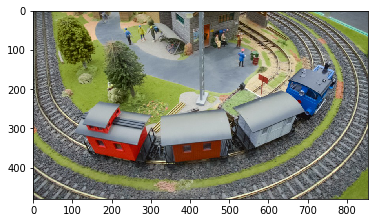

float32
(240, 427, 3)


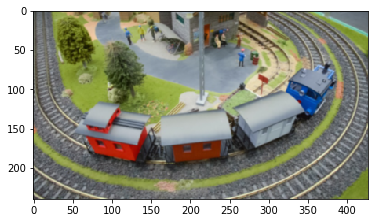

float32
(120, 213, 3)


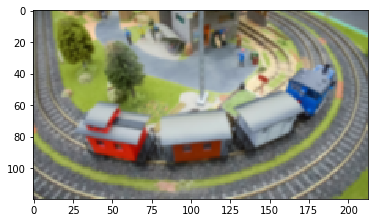

float32
(60, 106, 3)


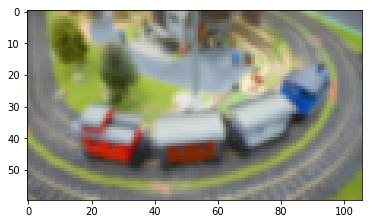

('Pyramid level: ', 3)
Iteration 0
inner loop
solving linear system
('Photo Loss:', 23.796679)
Iteration 1
inner loop
solving linear system
('Photo Loss:', 14.190147)
Iteration 2
inner loop
solving linear system
('Photo Loss:', 16.27872)
('Pyramid level: ', 2)
Iteration 0
inner loop
solving linear system
('Photo Loss:', 29.473227)
Iteration 1
inner loop
solving linear system
('Photo Loss:', 36.134136)
Iteration 2
inner loop
solving linear system
('Photo Loss:', 26.482952)
('Pyramid level: ', 1)
Iteration 0
inner loop
solving linear system
('Photo Loss:', 51.400726)
Iteration 1
inner loop
solving linear system
('Photo Loss:', 41.25457)
Iteration 2
inner loop
solving linear system
('Photo Loss:', 38.92119)
('Pyramid level: ', 0)
Iteration 0
inner loop
solving linear system
('Photo Loss:', 89.260994)
Iteration 1
inner loop
solving linear system
('Photo Loss:', 90.44265)
Iteration 2
inner loop
solving linear system
('Photo Loss:', 80.42005)


In [11]:
uv = compute_flow(images, np.zeros((H, W, 2),dtype=np.float32))

max flow: 15.1420
flow range:
u = -12.000 .. 10.389
v = -9.235 .. 12.000


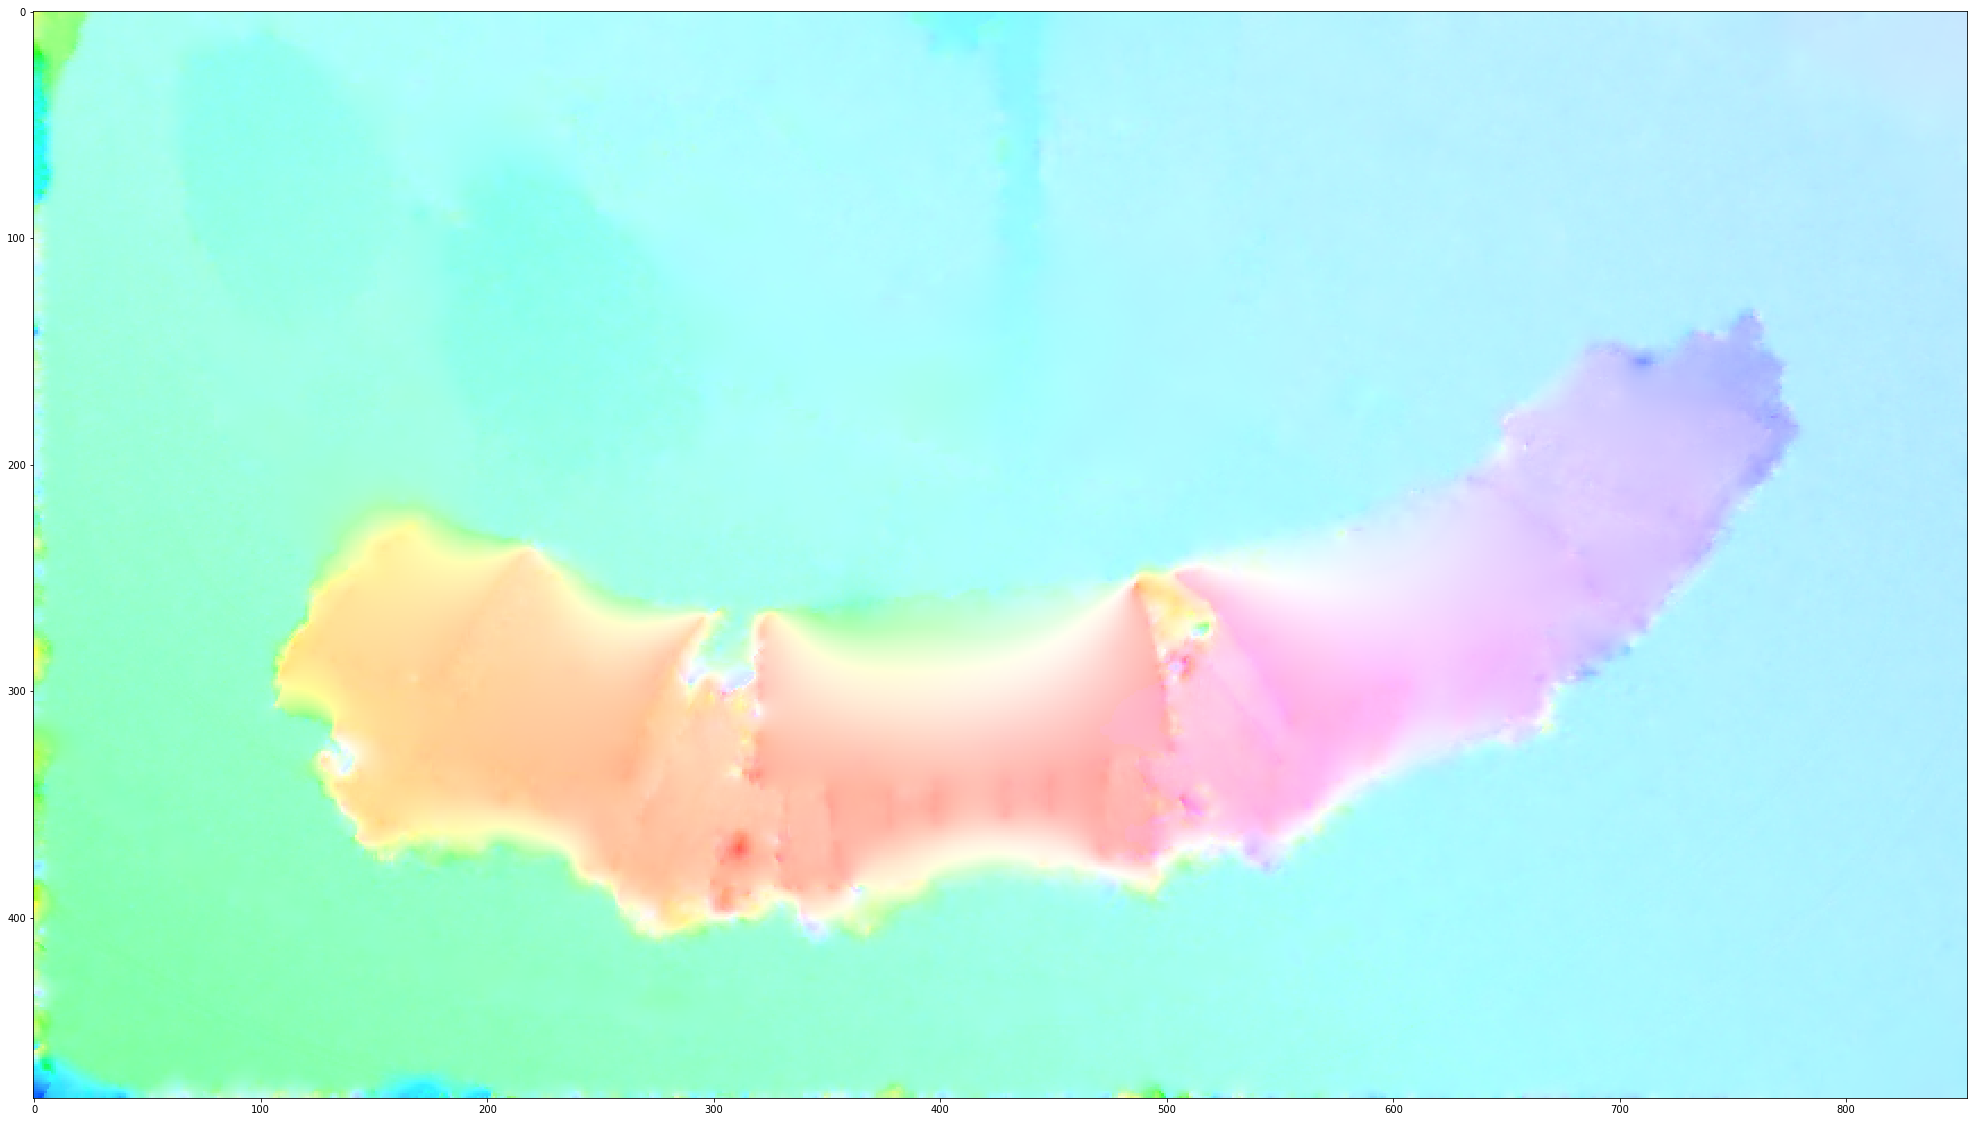

In [12]:
plt.figure(figsize=(40, 20))
plt.imshow(flow_to_image(np.clip(uv, -12, 12)))